In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix,recall_score,precision_score

from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import RandomOverSampler,ADASYN,SMOTE
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=Warning)

from collections import Counter

In [28]:
def rellenarNan(df,n,columnas_anuales,verbose=0):

    df_copia = df.copy()
    extremos = 0
    grupos_3 = 0
    grupos_4 = 0
    grupos_5 = 0

    indices = range(n-1,-1,-1)

    print('------------Rellenando extremos----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[0]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[1]))])==False:
                    df_copia.loc[j,columna +'-{}'.format(str(indices[0]))] = df_copia.loc[j, columna +'-{}'.format(str(indices[1]))]
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[0]))],df.loc[j,columna +'-{}'.format(str(indices[1]))])
                    extremos += 1

            if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[-1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[-2]))])==False:
                    df_copia.loc[j, columna +'-{}'.format(str(indices[-1]))] = df_copia.loc[j, columna +'-{}'.format(str(indices[-2]))]
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[-2]))],df.loc[j,columna +'-{}'.format(str(indices[-1]))])
                    extremos += 1

    print('------------Rellenando Dato-NaN-Dato----------')
    # Si hay dato-nan-dato, que se llene con la media
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-3+1):
                if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==False:
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df_copia.loc[j,columna +'-{}'.format(str(indices[i]))] + df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))])/2
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))])
                    grupos_3 += 1

    # Si hay dato-nan-nan-dato, rellenamos con la progresión lineal
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-4+1):
                if  (np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df[columna +'-{}'.format(str(indices[i+2]))][j])==True and np.isnan(df[columna +'-{}'.format(str(indices[i+3]))][j])==False):
                    media  = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + df.loc[j,columna +'-{}'.format(str(indices[i+3]))])/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + media)/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))] = (df.loc[j,columna +'-{}'.format(str(indices[i+3]))] + media)/2
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))],df.loc[j,columna +'-{}'.format(str(indices[i+3]))])
                    grupos_4 += 2

    # Si hay dato-nan-nan-nan-dato, rellenamos el del medio con la media
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-5+1):
                if  (np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+3]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+4]))])==False):
                    media  = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + df.loc[j,columna +'-{}'.format(str(indices[i+4]))])/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))] = media
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))],df.loc[j,columna +'-{}'.format(str(indices[i+3]))],df.loc[j,columna +'-{}'.format(str(indices[i+4]))])
                    grupos_5 += 1



    if(grupos_5>0):
        df = df_copia
        df_copia = df.copy()
        print('------------Rellenando Dato-NaN-Dato----------')
        # Si hay dato-nan-dato, que se llene con la media
        for j in range(len(df)):
            for columna in columnas_anuales:
                for i in range(len(indices)-3+1):
                    if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==False:
                        df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df_copia.loc[j,columna +'-{}'.format(str(indices[i]))] + df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))])/2
                        if verbose:
                            print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))])
                        grupos_3 += 1


    print('Extremos',extremos)
    print('Grupo 3', grupos_3)
    print('Grupo 4',grupos_4)
    print('Grupo 5',grupos_5)
    print('TOTAL',extremos+grupos_3+grupos_4+grupos_5)
    return df_copia



def rellenarNanHaciaAtras(df,n,columnas_anuales):
    df_copia = df.copy()
    rellenados = 0

    print('------------Rellenando hacia atras----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            media = 0
            for i in range(n):
                if(media != np.nan):
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]):
                        df_copia.loc[j,columna+'-{}'.format(i)]=media
                        rellenados += 1
                    else:
                        media = (media + df.loc[j,columna+'-{}'.format(i)])/2
                else:
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]) == False:
                        media = df.loc[j,columna+'-{}'.format(i)]

    return df_copia

def rellenarNanHaciaAdelante(df,n,columnas_anuales):
    df_copia = df.copy()
    rellenados = 0

    print('------------Rellenando hacia adelante----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            media = np.nan
            for i in range(n-1,-1,-1):
                if(media != np.nan):
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]):
                        df_copia.loc[j,columna+'-{}'.format(i)]=media
                        rellenados += 1
                    else:
                        media = (media + df.loc[j,columna+'-{}'.format(i)])/2
                else:
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]) == False:
                        media = df.loc[j,columna+'-{}'.format(i)]

    return df_copia

def eliminarFilasVacias(df,n,columnas_anuales,verbose=0):
    df_copia = df.copy()
    eliminados = 0

    print('------------Eliminamos aquellas filas con alguna variable anual completamente vacia, de las no extintas----------')

    for j in range(len(df)):
        if df.loc[j,'Y'] == 0:
            ya_eliminada = False
            for columna in columnas_anuales:
                if ya_eliminada == False:
                    vacias = 0
                    for i in range(n):
                        if(np.isnan(df.loc[j,columna+'-{}'.format(i)])):
                            vacias +=1
                    if vacias == n:
                        if verbose:
                            print(j,'-->',repr(columna))
                        df_copia.drop(j,axis=0,inplace=True)
                        eliminados += 1
                        ya_eliminada = True

    print(eliminados)
    df_copia.reset_index(drop=True,inplace=True)
    return df_copia

def limpiar(df,n,columnas_anuales,verbose=0):

    # Eliminamos aquellas filas (cuya etiqueta sea '0'), que para alguna variable anualizada tenga todos los valores vacios
    df = eliminarFilasVacias(df,n,columnas_anuales,verbose)
    # Rellenamos aquellos huecos que permitan extrapolar algo (grupos de 3, 4 y 5)
    df = rellenarNan(df,n,columnas_anuales,verbose)
    # Rellenamos los valores perdidos hacia atras
    df = rellenarNanHaciaAtras(df,n,columnas_anuales)
    # Rellenamos los valores perdidos hacia delante
    df = rellenarNanHaciaAdelante(df,n,columnas_anuales)

    return df

In [29]:
df_cnae55 = pd.read_csv('Datos/CNAE55-5años.csv')
df_cnae55.drop(df_cnae55.columns[df_cnae55.columns.str.contains('Unnamed: 0',case = False)],axis = 1, inplace = True)
df_cnae55['CNAE55'] = 1
df_cnae55['CNAE56'] = 0

In [30]:
df_cnae55

Y                                    Nombre Ultimo año disponible  \
0     0            1881 HOTELS SOCIEDAD LIMITADA.            31/12/2020   
1     1                  1900 CAT SL (EXTINGUIDA)            31/12/2009   
2     0                 2002 CARDENAL BENLLOCH SL            31/12/2020   
3     0                            2004 GODISA SL            31/12/2020   
4     0                         2005 HOTELES 2 SL            31/12/2020   
...  ..                                       ...                   ...   
3983  0                          ZENSUR HOTEL SL.            31/12/2020   
3984  0  ZINNIA HOTEL ALGECIRAS SOCIEDAD LIMITADA            31/12/2020   
3985  0                                ZORAIDA SA            31/12/2020   
3986  0                               ZUBAROSI SA            31/12/2020   
3987  0                             ÑAM BILBAO SL            31/12/2020   

     Fecha constitución Fecha cambio estado  \
0              4/8/2006          22/12/2011   
1            31/12/1996           25/3/2011   
2             19/4/2002           19/4/2002   
3             11/8/2004           11/8/2004   
4             18/7/2005           18/7/2005   
...                 ...                 ...   
3983         12/12/2013          12/12/2013   
3984         29/12/2010           24/6/2019   
3985          19/7/1971           19/7/1971   
3986          25/4/1973           20/6/1979   
3987          30/3/1994           30/3/1994   

      Rentabilidad sobre recursos propios (%)\n%\n-4  \
0                                              34.20   
1                                               9.51   
2                                               2.97   
3                                               1.89   
4                                             -16.87   
...                                              ...   
3983                                           69.62   
3984                                             NaN   
3985                                           46.34   
3986                                            4.84   
3987                                            5.04   

      Rentabilidad sobre recursos propios (%)\n%\n-3  \
0                                             -20.44   
1                                               1.05   
2                                              50.02   
3                                               1.14   
4                                             -35.39   
...                                              ...   
3983                                           42.43   
3984                                             NaN   
3985                                           48.50   
3986                                            2.72   
3987                                            3.03   

      Rentabilidad sobre recursos propios (%)\n%\n-2  \
0                                              12.06   
1                                              19.91   
2                                               7.87   
3                                               2.37   
4                                              21.64   
...                                              ...   
3983                                           39.35   
3984                                         -131.28   
3985                                           68.93   
3986                                            3.21   
3987                                            3.79   

      Rentabilidad sobre recursos propios (%)\n%\n-1  \
0                                               2.76   
1                                               5.91   
2                                               8.54   
3                                               0.32   
4                                              16.92   
...                                              ...   
3983                                            6.93   
3984                                          -26.10   
3985             

In [31]:
df_cnae56 = pd.read_csv('Datos/CNAE56-5años.csv')
df_cnae56.drop(df_cnae56.columns[df_cnae56.columns.str.contains('Unnamed: 0',case = False)],axis = 1, inplace = True)
df_cnae56['CNAE55'] = 0
df_cnae56['CNAE56'] = 1

In [32]:
df_cnae56

Y                               Nombre Ultimo año disponible  \
0     0                    051-MADE IN BO SL            31/12/2021   
1     0                      1001PRADO16 SL.            31/12/2020   
2     0                       100EMOCIONS SL            31/12/2021   
3     0                      100M ATOCHA SL.            31/12/2021   
4     0                       101 BOCATAS SL            31/12/2021   
...  ..                                  ...                   ...   
9588  0                 ZULE RESTAURANTES SL            31/12/2021   
9589  1          ZURITA 15 S.L. (EXTINGUIDA)            31/12/2007   
9590  0                        ZURRIONDA SL.            31/12/2020   
9591  0         ÑAM ARTEA SOCIEDAD LIMITADA.            31/12/2021   
9592  0  ÑAM RESTAURANTES SOCIEDAD LIMITADA.            31/12/2021   

       Fecha constitución Fecha cambio estado  \
0     2006-11-17 00:00:00          2018-09-21   
1     2010-02-12 00:00:00          2010-03-03   
2     2005-07-19 00:00:00          2020-01-30   
3     2009-09-10 00:00:00          2018-11-01   
4     1998-07-23 00:00:00          1998-07-23   
...                   ...                 ...   
9588  2011-11-02 00:00:00          2011-11-02   
9589  1998-12-30 00:00:00          2008-12-01   
9590  2015-01-07 00:00:00          2015-01-07   
9591  2013-11-27 00:00:00          2013-11-27   
9592  2000-12-27 00:00:00          2012-10-19   

      Rentabilidad sobre recursos propios (%)\n%\n-4  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                              9.803   
...                                              ...   
9588                                             NaN   
9589                                             NaN   
9590                                             NaN   
9591                                             NaN   
9592                                          39.408   

      Rentabilidad sobre recursos propios (%)\n%\n-3  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                             14.578   
...                                              ...   
9588                                             NaN   
9589                                          43.840   
9590                                             NaN   
9591                                             NaN   
9592                                          35.496   

      Rentabilidad sobre recursos propios (%)\n%\n-2  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                             11.089   
...                                              ...   
9588                                             NaN   
9589                                          45.890   
9590                                             NaN   
9591                                             NaN   
9592                                          38.099   

      Rentabilidad sobre recursos propios (%)\n%\n-1  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                          -3258.273   
...                                              ...   
9588                                             NaN   
9589                                          26.827   
9590                                             NaN 

In [33]:
df_cnae55.columns

Index(['Y', 'Nombre', 'Ultimo año disponible', 'Fecha constitución',
       'Fecha cambio estado', 'Rentabilidad sobre recursos propios (%)\n%\n-4',
       'Rentabilidad sobre recursos propios (%)\n%\n-3',
       'Rentabilidad sobre recursos propios (%)\n%\n-2',
       'Rentabilidad sobre recursos propios (%)\n%\n-1',
       'Rentabilidad sobre recursos propios (%)\n%\n-0',
       ...
       'Apalancamiento (%)\n%\n-2', 'Apalancamiento (%)\n%\n-1',
       'Apalancamiento (%)\n%\n-0', 'Ratio de solvencia\n%\n-4',
       'Ratio de solvencia\n%\n-3', 'Ratio de solvencia\n%\n-2',
       'Ratio de solvencia\n%\n-1', 'Ratio de solvencia\n%\n-0', 'CNAE55',
       'CNAE56'],
      dtype='object', length=132)

In [34]:
df_cnae56.columns

Index(['Y', 'Nombre', 'Ultimo año disponible', 'Fecha constitución',
       'Fecha cambio estado', 'Rentabilidad sobre recursos propios (%)\n%\n-4',
       'Rentabilidad sobre recursos propios (%)\n%\n-3',
       'Rentabilidad sobre recursos propios (%)\n%\n-2',
       'Rentabilidad sobre recursos propios (%)\n%\n-1',
       'Rentabilidad sobre recursos propios (%)\n%\n-0',
       ...
       'Apalancamiento (%)\n%\n-2', 'Apalancamiento (%)\n%\n-1',
       'Apalancamiento (%)\n%\n-0', 'Ratio de solvencia\n%\n-4',
       'Ratio de solvencia\n%\n-3', 'Ratio de solvencia\n%\n-2',
       'Ratio de solvencia\n%\n-1', 'Ratio de solvencia\n%\n-0', 'CNAE55',
       'CNAE56'],
      dtype='object', length=132)

In [35]:
df_completo = pd.concat([df_cnae55,df_cnae56],ignore_index=True)
df_completo

Y                               Nombre Ultimo año disponible  \
0      0       1881 HOTELS SOCIEDAD LIMITADA.            31/12/2020   
1      1             1900 CAT SL (EXTINGUIDA)            31/12/2009   
2      0            2002 CARDENAL BENLLOCH SL            31/12/2020   
3      0                       2004 GODISA SL            31/12/2020   
4      0                    2005 HOTELES 2 SL            31/12/2020   
...   ..                                  ...                   ...   
13576  0                 ZULE RESTAURANTES SL            31/12/2021   
13577  1          ZURITA 15 S.L. (EXTINGUIDA)            31/12/2007   
13578  0                        ZURRIONDA SL.            31/12/2020   
13579  0         ÑAM ARTEA SOCIEDAD LIMITADA.            31/12/2021   
13580  0  ÑAM RESTAURANTES SOCIEDAD LIMITADA.            31/12/2021   

        Fecha constitución Fecha cambio estado  \
0                 4/8/2006          22/12/2011   
1               31/12/1996           25/3/2011   
2                19/4/2002           19/4/2002   
3                11/8/2004           11/8/2004   
4                18/7/2005           18/7/2005   
...                    ...                 ...   
13576  2011-11-02 00:00:00          2011-11-02   
13577  1998-12-30 00:00:00          2008-12-01   
13578  2015-01-07 00:00:00          2015-01-07   
13579  2013-11-27 00:00:00          2013-11-27   
13580  2000-12-27 00:00:00          2012-10-19   

       Rentabilidad sobre recursos propios (%)\n%\n-4  \
0                                              34.200   
1                                               9.510   
2                                               2.970   
3                                               1.890   
4                                             -16.870   
...                                               ...   
13576                                             NaN   
13577                                             NaN   
13578                                             NaN   
13579                                             NaN   
13580                                          39.408   

       Rentabilidad sobre recursos propios (%)\n%\n-3  \
0                                             -20.440   
1                                               1.050   
2                                              50.020   
3                                               1.140   
4                                             -35.390   
...                                               ...   
13576                                             NaN   
13577                                          43.840   
13578                                             NaN   
13579                                             NaN   
13580                                          35.496   

       Rentabilidad sobre recursos propios (%)\n%\n-2  \
0                                              12.060   
1                                              19.910   
2                                               7.870   
3                                               2.370   
4                                              21.640   
...                                               ...   
13576                                             NaN   
13577                                          45.890   
13578                                             NaN   
13579                                             NaN   
13580                                          38.099   

       Rentabilidad sobre recursos propios (%)\n%\n-1  \
0                                               2.760   
1                                               5.910   
2                                               8.540   
3                                               0.320   
4                                              16.920   
...                                               ...   
13576                                             NaN   
13577                                     

In [36]:
df_anuales = df_completo.columns[df_completo.columns.str.contains('-4',case = False)]

columnas_anuales = []

for col in df_anuales:
    columnas_anuales.append(col[:-2])

columnas_anuales

['Rentabilidad sobre recursos propios (%)\n%\n',
 'Rentabilidad sobre capital empleado (%)\n%\n',
 'Rentabilidad sobre el activo total (%)\n%\n',
 'Margen de beneficio (%)\n%\n',
 'Rotación de activos netos\n%\n',
 'Ratio de cobertura de intereses\n%\n',
 'Rotación de las existencias\n%\n',
 'Período de cobro (días)\ndías\n',
 'Período de crédito (días)\ndías\n',
 'Costes de los trabajadores / Ingresos de explotación (%)\n%\n',
 'Coste medio de los empleados\nmil\n',
 'Capital circulante por empleado\nmil\n',
 'Ingresos de explotación\nEUR\n',
 'Result. ordinarios antes Impuestos\nEUR\n',
 'Resultado del Ejercicio\nEUR\n',
 'Total Activo\nEUR\n',
 'Fondos propios\nEUR\n',
 'Rentabilidad económica (%)\n%\n',
 'Rentabilidad financiera (%)\n%\n',
 'Liquidez general\n%\n',
 'Endeudamiento (%)\n%\n',
 'Número empleados\n',
 'Ratios de autonomía financiera a medio y largo plazo\n%\n',
 'Apalancamiento (%)\n%\n',
 'Ratio de solvencia\n%\n']

In [37]:
df = limpiar(df_completo,5,columnas_anuales,verbose=0)

------------Eliminamos aquellas filas con alguna variable anual completamente vacia, de las no extintas----------
6844
------------Rellenando extremos----------
------------Rellenando Dato-NaN-Dato----------
------------Rellenando Dato-NaN-Dato----------
Extremos 9780
Grupo 3 8451
Grupo 4 3874
Grupo 5 349
TOTAL 22454
------------Rellenando hacia atras----------
------------Rellenando hacia adelante----------


In [38]:
df

Y                               Nombre Ultimo año disponible  \
0     0       1881 HOTELS SOCIEDAD LIMITADA.            31/12/2020   
1     1             1900 CAT SL (EXTINGUIDA)            31/12/2009   
2     0            2002 CARDENAL BENLLOCH SL            31/12/2020   
3     0                       2004 GODISA SL            31/12/2020   
4     0                    2005 HOTELES 2 SL            31/12/2020   
...  ..                                  ...                   ...   
6732  1      ZONA FUENCARRAL SL (EXTINGUIDA)            31/12/2020   
6733  1  ZONA GASTRONOMICA S.L. (EXTINGUIDA)            31/12/2015   
6734  0               ZUBEROA JATETXEA S. L.            31/12/2021   
6735  1          ZURITA 15 S.L. (EXTINGUIDA)            31/12/2007   
6736  0  ÑAM RESTAURANTES SOCIEDAD LIMITADA.            31/12/2021   

       Fecha constitución Fecha cambio estado  \
0                4/8/2006          22/12/2011   
1              31/12/1996           25/3/2011   
2               19/4/2002           19/4/2002   
3               11/8/2004           11/8/2004   
4               18/7/2005           18/7/2005   
...                   ...                 ...   
6732  1998-09-22 00:00:00          2022-01-10   
6733  2006-10-25 00:00:00          2021-01-28   
6734  1986-03-05 00:00:00          2017-12-21   
6735  1998-12-30 00:00:00          2008-12-01   
6736  2000-12-27 00:00:00          2012-10-19   

      Rentabilidad sobre recursos propios (%)\n%\n-4  \
0                                             34.200   
1                                              9.510   
2                                              2.970   
3                                              1.890   
4                                            -16.870   
...                                              ...   
6732                                           0.000   
6733                                         -93.111   
6734                                          11.768   
6735                                          43.840   
6736                                          39.408   

      Rentabilidad sobre recursos propios (%)\n%\n-3  \
0                                            -20.440   
1                                              1.050   
2                                             50.020   
3                                              1.140   
4                                            -35.390   
...                                              ...   
6732                                           0.000   
6733                                          -8.644   
6734                                          14.282   
6735                                          43.840   
6736                                          35.496   

      Rentabilidad sobre recursos propios (%)\n%\n-2  \
0                                             12.060   
1                                             19.910   
2                                              7.870   
3                                              2.370   
4                                             21.640   
...                                              ...   
6732                                           0.000   
6733                                           9.961   
6734                                           9.996   
6735                                          45.890   
6736                                          38.099   

      Rentabilidad sobre recursos propios (%)\n%\n-1  \
0                                              2.760   
1                                              5.910   
2                                              8.540   
3                                              0.320   
4                                             16.920   
...                                              ...   
6732                                           0.000   
6733                                          25.522   
6734                                          -5.110 

In [39]:
print('Numero de datos (incluido perdidos):',df.size)
print('Numero de datos perdidos:',df.isnull().values.sum())
print('Porcentaje de datos perdidos:',(df.isnull().values.sum()/df.size)*100.0,'%')

Numero de datos (incluido perdidos): 889284
Numero de datos perdidos: 5
Porcentaje de datos perdidos: 0.0005622500798395113 %


In [40]:
X = df.copy()
Y = X['Y']
X.drop('Y',inplace=True,axis=1)

X.drop(['Nombre','Ultimo año disponible','Fecha constitución','Fecha cambio estado'],inplace=True,axis=1)

In [41]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33)

In [42]:
print('Conjunto de entrenamiento %s' % Counter(Y_train))
print('Conjunto de prueba %s' % Counter(Y_test))

Conjunto de entrenamiento Counter({0: 3638, 1: 875})
Conjunto de prueba Counter({0: 1854, 1: 370})


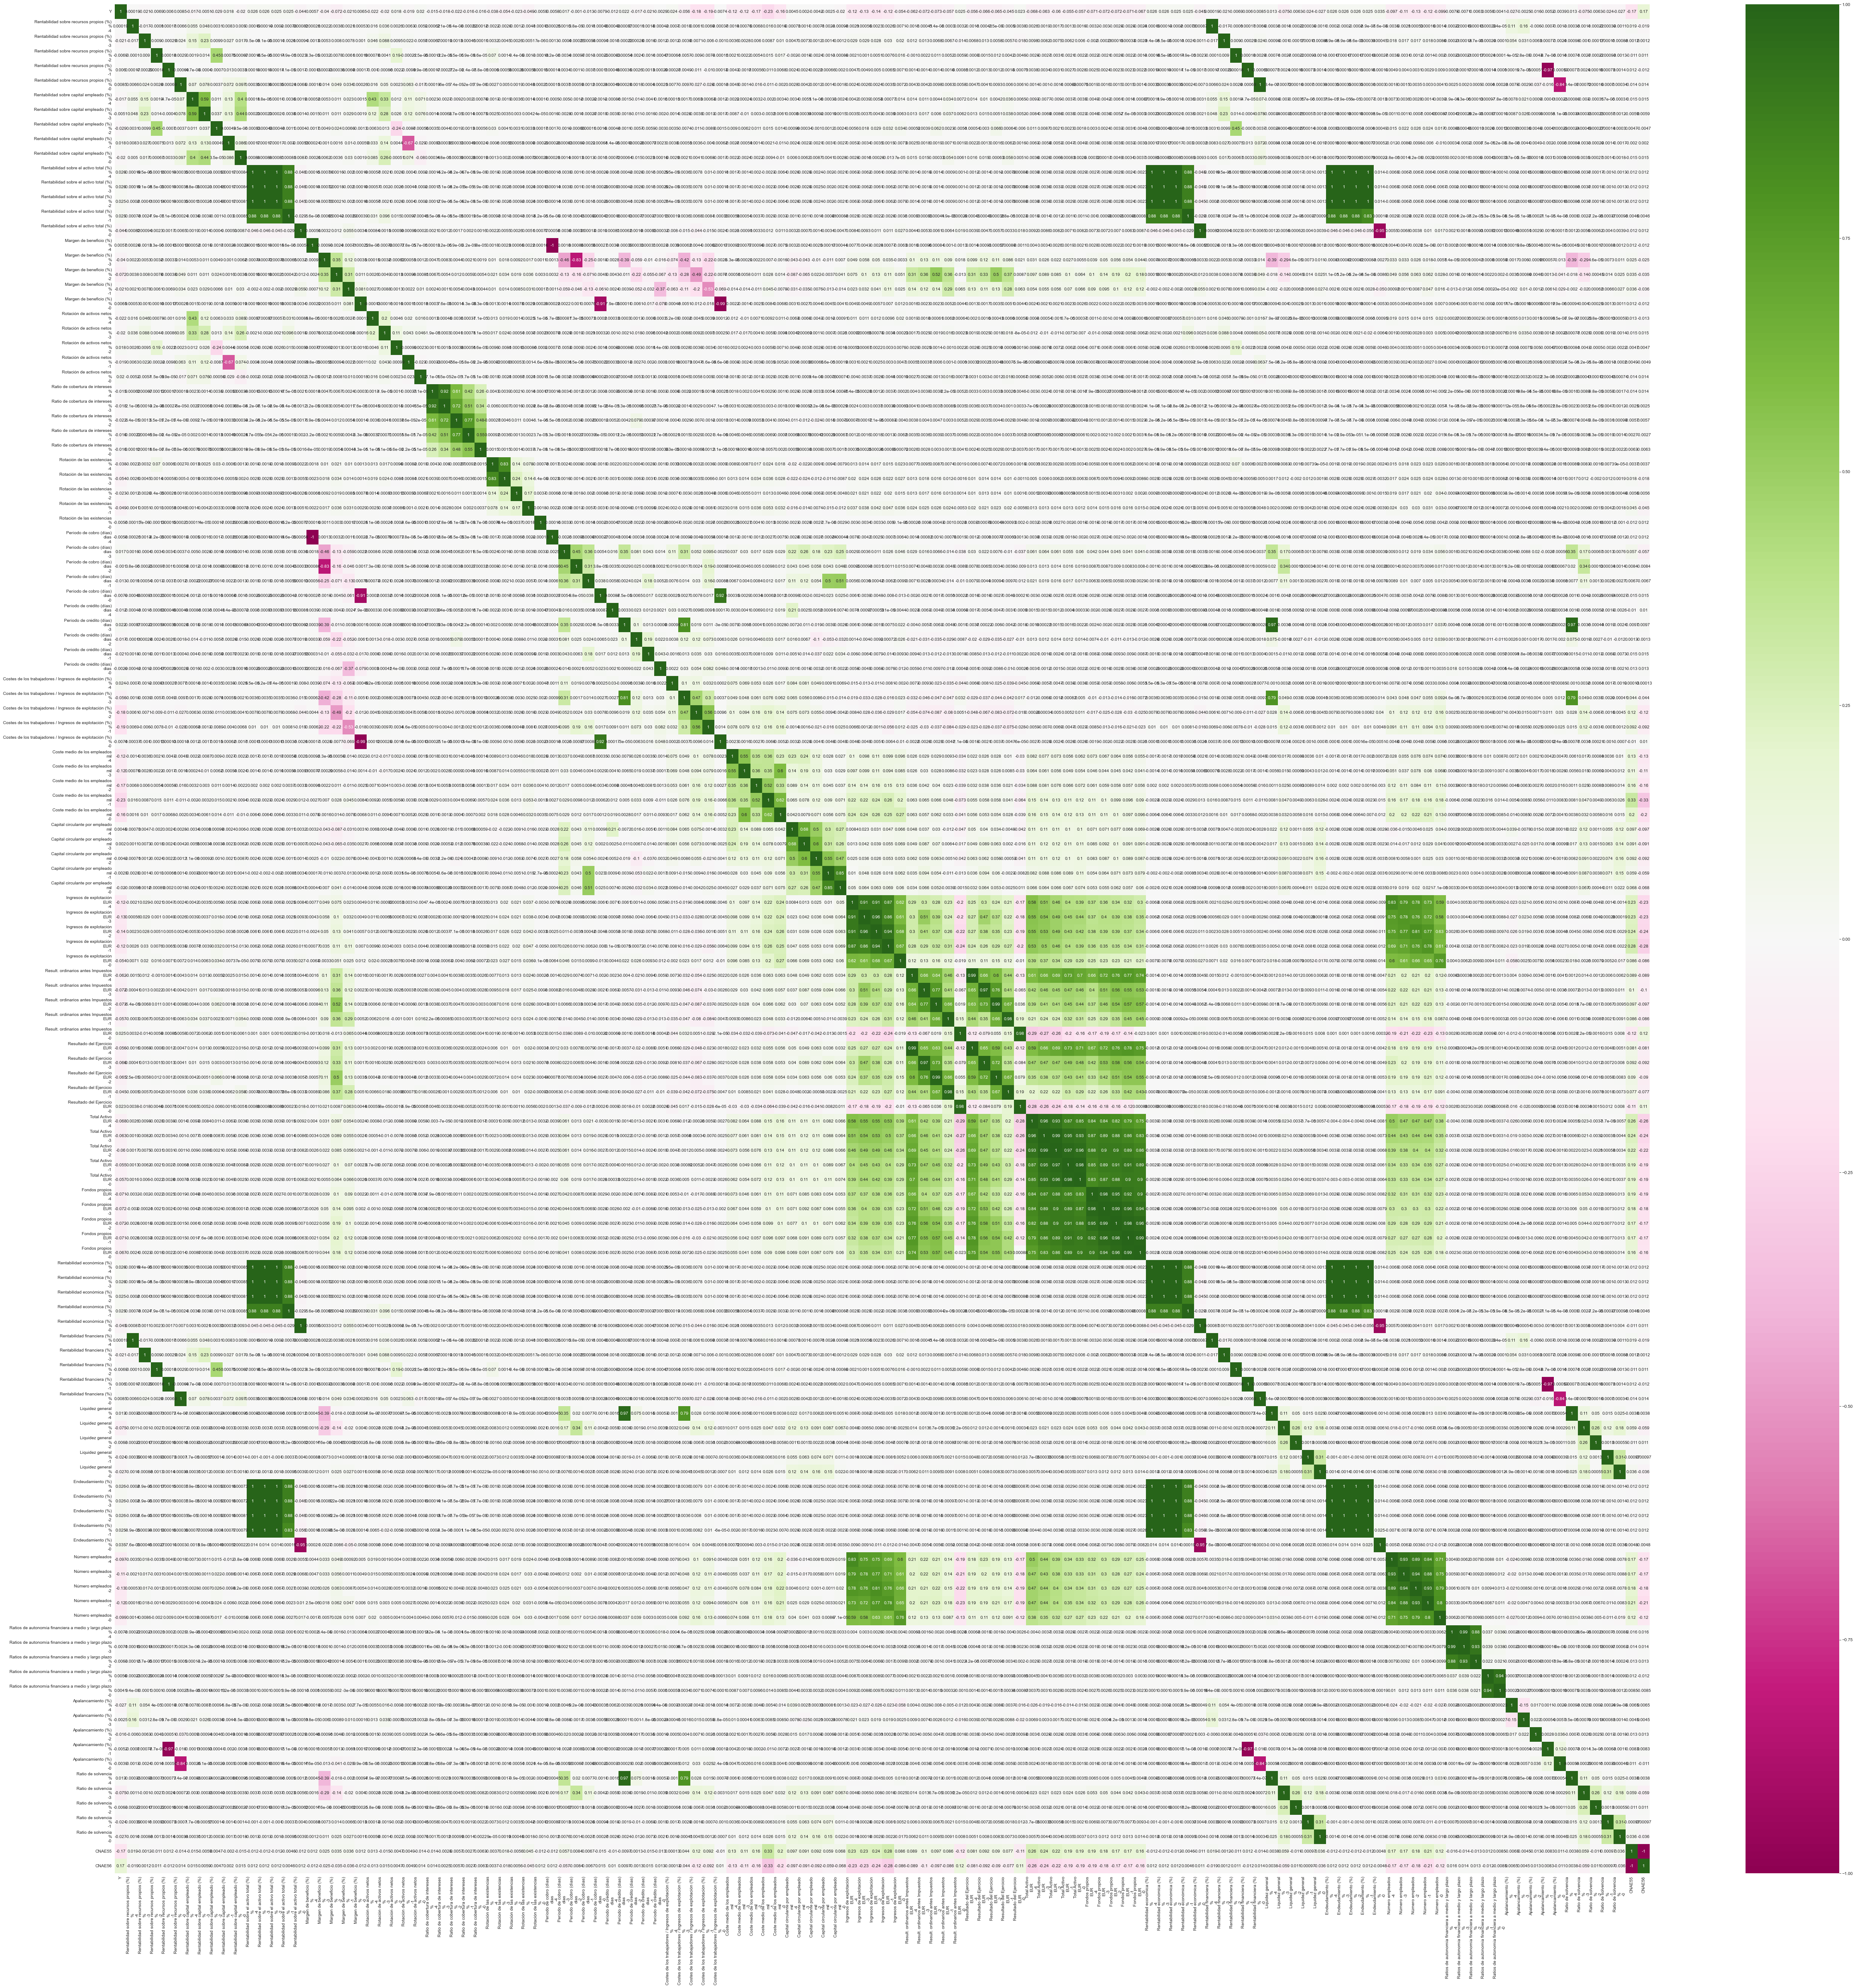

In [43]:
from seaborn import heatmap
plt.figure(figsize=(80,80))
heatmap(df.corr(),annot=True,cmap="PiYG");

## Baseline

Buscando (SVM)
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.13% test recall 28.65% test precision 100.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 89.25% test recall 38.38% test precision 92.81%


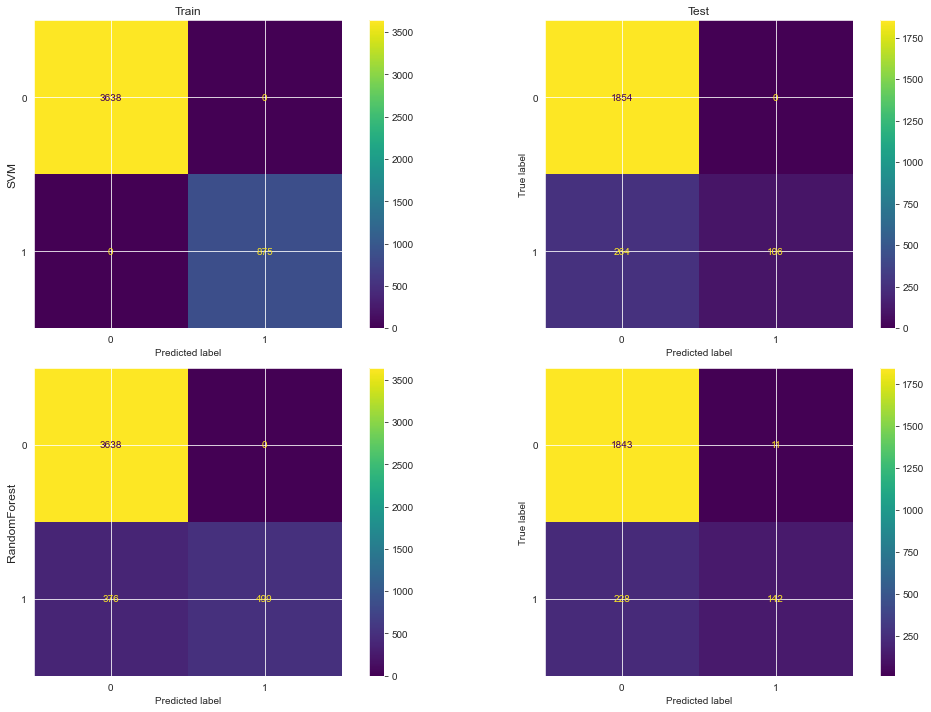

In [44]:
### APARECIDOS
param_svm = {
    'C' : [0.0001,0.001,1,5,10],
    'kernel': ['rbf'],
    'gamma' :[0.0001,0.0005,0.005]
}


param_rf = {
    'n_estimators':[150,200,250,300],
    'max_depth' : [6,7,8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}

modelos = ['SVM','RandomForest']
estimators = [SVC(),RandomForestClassifier()]
parametros = [param_svm,param_rf]
entrenados = []



fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))

for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
    busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
    busqueda.fit(X_train,Y_train)
    print('Buscando ({})'.format(modelo))
    print('Mejores parametros:',busqueda.best_params_)
    print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                    recall_score(Y_test,busqueda.predict(X_test)),
                                                                                    precision_score(Y_test,busqueda.predict(X_test))))

    plot_confusion_matrix(busqueda,
                        X_train,
                        Y_train,
                        ax=axes[ind,0])
    #axes[ind,0].title.set_text('Train')

    plot_confusion_matrix(busqueda,
                        X_test,
                        Y_test,
                        ax=axes[ind,1])
    #axes[ind,1].title.set_text('Test')

    entrenados.append(busqueda)

for ax,col in zip(axes[0],['Train','Test']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], modelos):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
plt.show()

## Baseline Deltas

In [45]:
df_deltas = df.copy()

In [46]:
def calcularDeltas(df,n,columnas_anuales):
    df_nuevo = df.copy()

    indices = range(n-1,-1,-1)

    for columna in columnas_anuales:
        for i in range(len(indices)-1):
            df_nuevo[columna+'delta {}-{}'.format(indices[i],indices[i+1])] = ((df_nuevo[columna+'-{}'.format(indices[i+1])]/df_nuevo[columna+'-{}'.format(indices[i])])-1.0)*100

    return df_nuevo

In [47]:
df_deltas = calcularDeltas(df_deltas,5,columnas_anuales)

In [48]:
pd.options.mode.use_inf_as_na = True
df_deltas.fillna(value=0.0,inplace=True)

In [49]:
df_deltas

Y                               Nombre Ultimo año disponible  \
0     0       1881 HOTELS SOCIEDAD LIMITADA.            31/12/2020   
1     1             1900 CAT SL (EXTINGUIDA)            31/12/2009   
2     0            2002 CARDENAL BENLLOCH SL            31/12/2020   
3     0                       2004 GODISA SL            31/12/2020   
4     0                    2005 HOTELES 2 SL            31/12/2020   
...  ..                                  ...                   ...   
6732  1      ZONA FUENCARRAL SL (EXTINGUIDA)            31/12/2020   
6733  1  ZONA GASTRONOMICA S.L. (EXTINGUIDA)            31/12/2015   
6734  0               ZUBEROA JATETXEA S. L.            31/12/2021   
6735  1          ZURITA 15 S.L. (EXTINGUIDA)            31/12/2007   
6736  0  ÑAM RESTAURANTES SOCIEDAD LIMITADA.            31/12/2021   

       Fecha constitución Fecha cambio estado  \
0                4/8/2006          22/12/2011   
1              31/12/1996           25/3/2011   
2               19/4/2002           19/4/2002   
3               11/8/2004           11/8/2004   
4               18/7/2005           18/7/2005   
...                   ...                 ...   
6732  1998-09-22 00:00:00          2022-01-10   
6733  2006-10-25 00:00:00          2021-01-28   
6734  1986-03-05 00:00:00          2017-12-21   
6735  1998-12-30 00:00:00          2008-12-01   
6736  2000-12-27 00:00:00          2012-10-19   

      Rentabilidad sobre recursos propios (%)\n%\n-4  \
0                                             34.200   
1                                              9.510   
2                                              2.970   
3                                              1.890   
4                                            -16.870   
...                                              ...   
6732                                           0.000   
6733                                         -93.111   
6734                                          11.768   
6735                                          43.840   
6736                                          39.408   

      Rentabilidad sobre recursos propios (%)\n%\n-3  \
0                                            -20.440   
1                                              1.050   
2                                             50.020   
3                                              1.140   
4                                            -35.390   
...                                              ...   
6732                                           0.000   
6733                                          -8.644   
6734                                          14.282   
6735                                          43.840   
6736                                          35.496   

      Rentabilidad sobre recursos propios (%)\n%\n-2  \
0                                             12.060   
1                                             19.910   
2                                              7.870   
3                                              2.370   
4                                             21.640   
...                                              ...   
6732                                           0.000   
6733                                           9.961   
6734                                           9.996   
6735                                          45.890   
6736                                          38.099   

      Rentabilidad sobre recursos propios (%)\n%\n-1  \
0                                              2.760   
1                                              5.910   
2                                              8.540   
3                                              0.320   
4                                             16.920   
...                                              ...   
6732                                           0.000   
6733                                          25.522   
6734                                          -5.110 

In [50]:
X_deltas = df_deltas.copy()
Y_deltas = X_deltas['Y']

X_deltas.drop(['Y','Nombre','Ultimo año disponible','Fecha constitución','Fecha cambio estado'],inplace=True,axis=1)

In [56]:
X_train_deltas,X_test_deltas,Y_train_deltas,Y_test_deltas = train_test_split(X_deltas,Y_deltas,test_size=0.33)

Buscando (SVM)
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 81.70% test recall 0.00% test precision 0.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200, 'random_state': 42}
test acurracy 88.67% test recall 39.07% test precision 97.55%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 90.38% test recall 53.32% test precision 90.04%


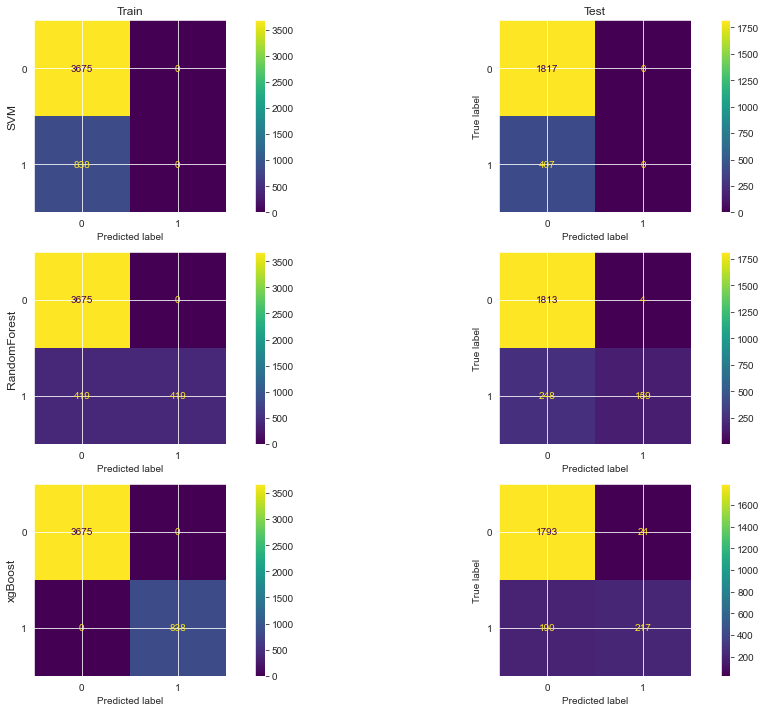

In [58]:
### APARECIDOS
param_svm = {
    'C' : [0.0001],
    'kernel': ['rbf'],
    'gamma' :[0.0001]
}


param_rf = {
    'n_estimators':[200],
    'max_depth' : [7],
    'criterion' : ['gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [7],
    'learning_rate' : [0.1],
    'n_estimators' : [300],
    'gamma' : [0],
    'reg_alpha' : [0.1],
    'random_state': [42]
}



modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
entrenados_delta_base = []



fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))

for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
    busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
    busqueda.fit(X_train_deltas,Y_train_deltas)
    print('Buscando ({})'.format(modelo))
    print('Mejores parametros:',busqueda.best_params_)
    print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test_deltas,Y_test_deltas),
                                                                                    recall_score(Y_test_deltas,busqueda.predict(X_test_deltas)),
                                                                                    precision_score(Y_test_deltas,busqueda.predict(X_test_deltas))))

    plot_confusion_matrix(busqueda,
                        X_train_deltas,
                        Y_train_deltas,
                        ax=axes[ind,0])
    #axes[ind,0].title.set_text('Train')

    plot_confusion_matrix(busqueda,
                        X_test_deltas,
                        Y_test_deltas,
                        ax=axes[ind,1])
    #axes[ind,1].title.set_text('Test')

    entrenados_delta_base.append(busqueda)

for ax,col in zip(axes[0],['Train','Test']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], modelos):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
plt.show()

## OVERSAMPLING OPTIMISTA

ROSE
Resampled dataset shape Counter({0: 3638, 1: 3638})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.13% test recall 28.65% test precision 100.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 150, 'random_state': 42}
test acurracy 88.04% test recall 61.89% test precision 64.69%


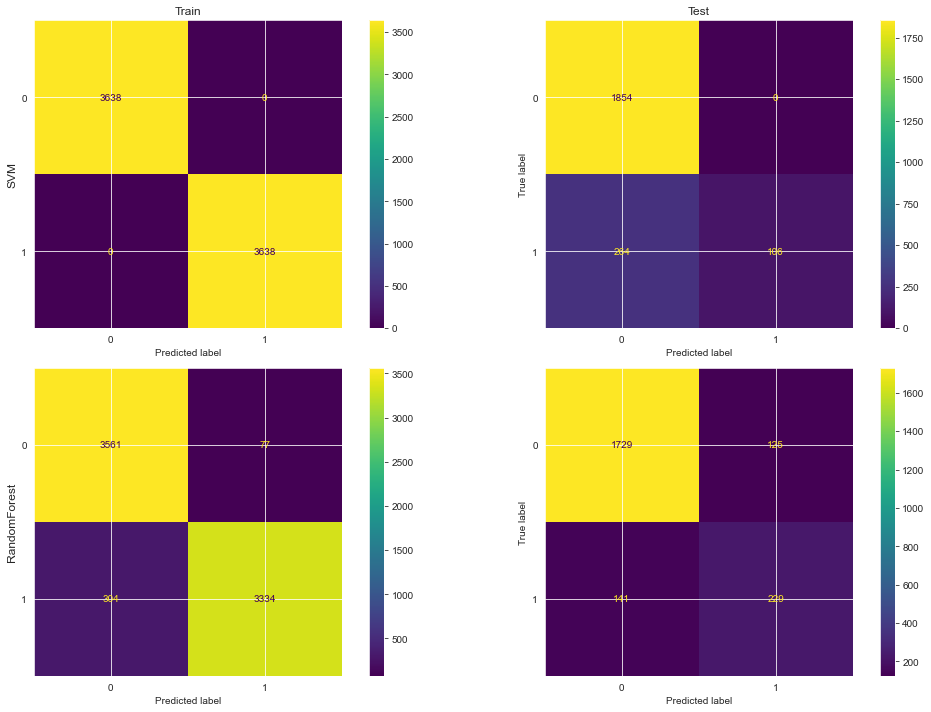

ADASYN
Resampled dataset shape Counter({1: 3749, 0: 3638})
SVM
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 16.64% test recall 100.00% test precision 16.64%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
test acurracy 79.09% test recall 72.43% test precision 42.47%


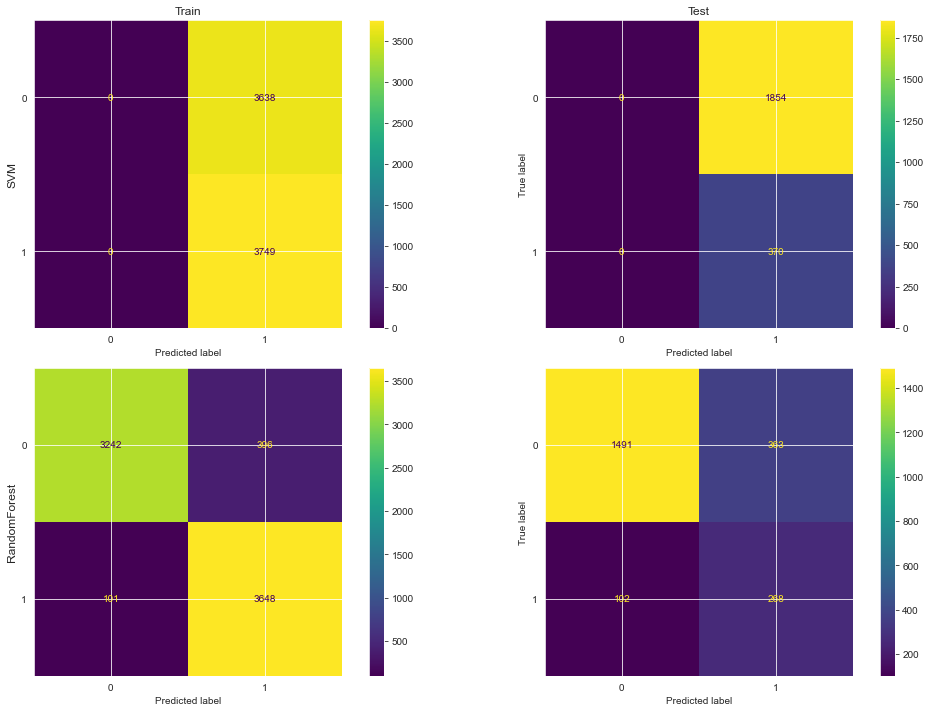

SMOTE
Resampled dataset shape Counter({0: 3638, 1: 3638})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.13% test recall 28.65% test precision 100.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 250, 'random_state': 42}
test acurracy 83.41% test recall 62.43% test precision 50.11%


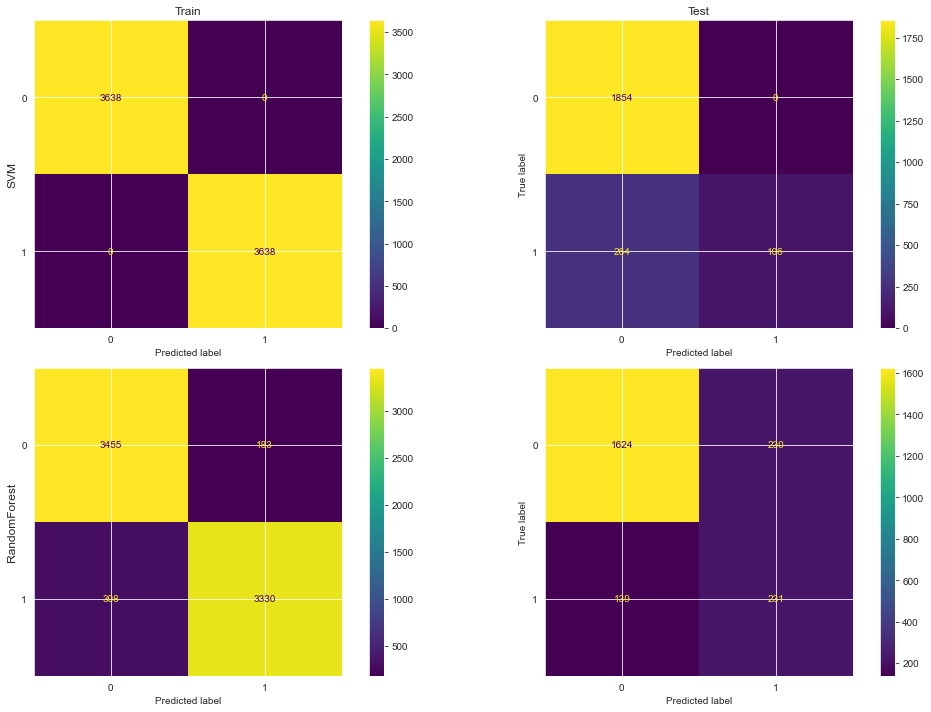

In [59]:
param_svm = {
    'C' : [0.0001,0.001,1,5,10],
    'kernel': ['rbf'],
    'gamma' :[0.0001,0.0005,0.005]
}




param_rf = {
    'n_estimators':[150,200,250,300],
    'max_depth' : [6,7,8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}


modelos = ['SVM','RandomForest']
estimators = [SVC(),RandomForestClassifier()]
parametros = [param_svm,param_rf]
oversampling = [RandomOverSampler(),ADASYN(),SMOTE()]
oversamplers = ['ROSE','ADASYN','SMOTE']
entrenados = []

for algo,sampler in zip(oversampling,oversamplers):
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    print(sampler)
    X_res, y_res = algo.fit_resample(X_train, Y_train)
    print('Resampled dataset shape %s' % Counter(y_res))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):

        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
        busqueda.fit(X_res,y_res)
        print(modelo)
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                     recall_score(Y_test,busqueda.predict(X_test)),
                                                                                     precision_score(Y_test,busqueda.predict(X_test))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

        for ax,col in zip(axes[0],['Train','Test']):
            ax.set_title(col)
        for ax, row in zip(axes[:,0], modelos):
            ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

## OVERSAMPLING PIPELINE

ROSE
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 88.13% test recall 28.65% test precision 100.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__random_state': 42}
test acurracy 88.31% test recall 62.97% test precision 65.45%


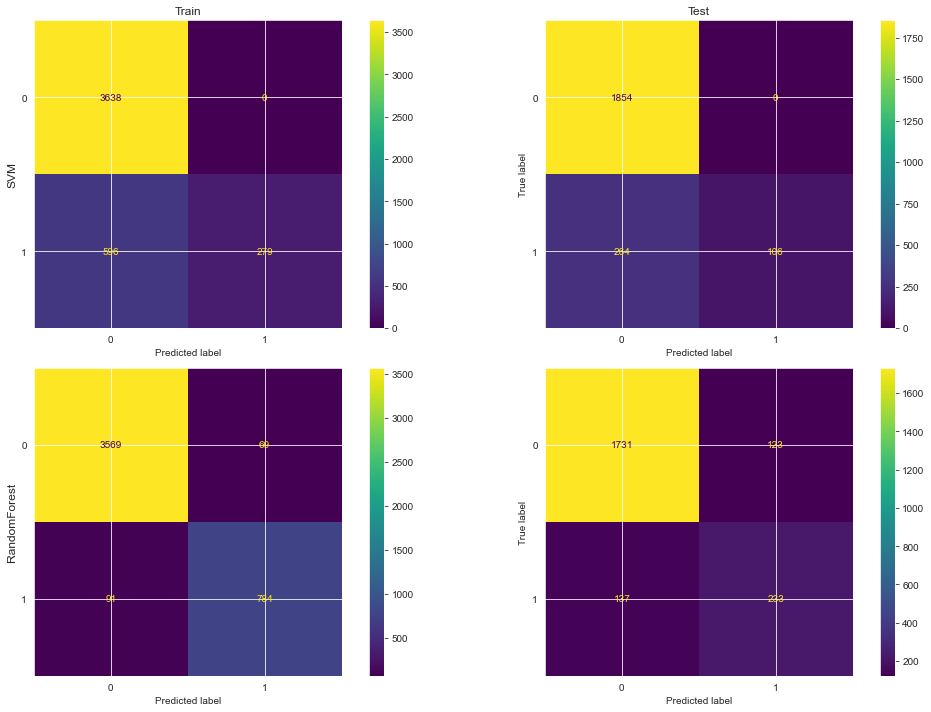

ADASYN
SVM
Mejores parametros: {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 88.13% test recall 28.65% test precision 100.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__random_state': 42}
test acurracy 79.45% test recall 73.24% test precision 43.08%


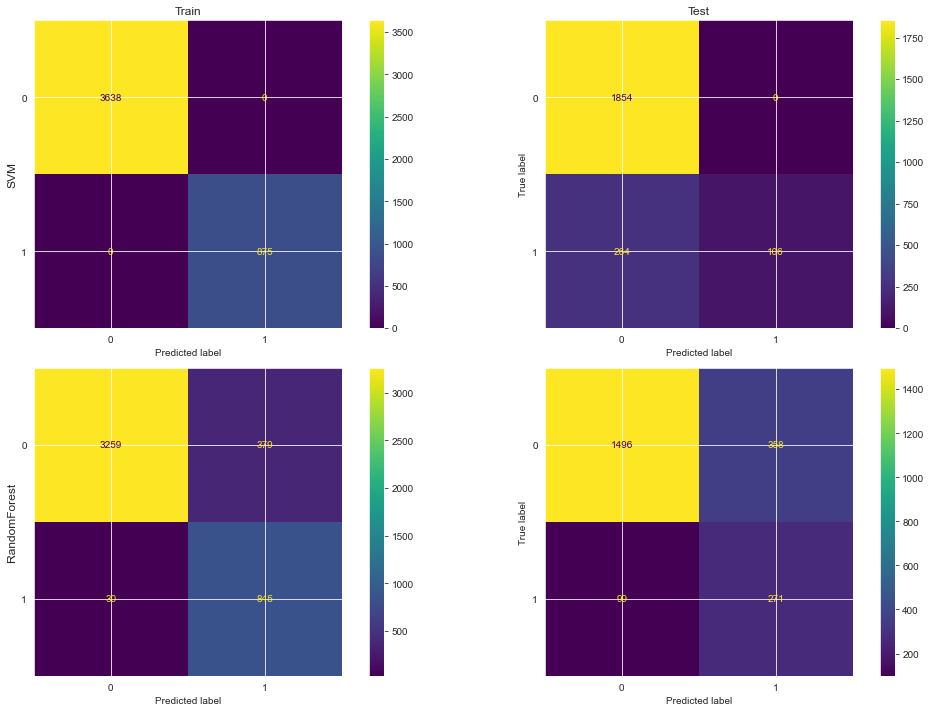

SMOTE
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 88.13% test recall 28.65% test precision 100.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__random_state': 42}
test acurracy 83.18% test recall 62.43% test precision 49.57%


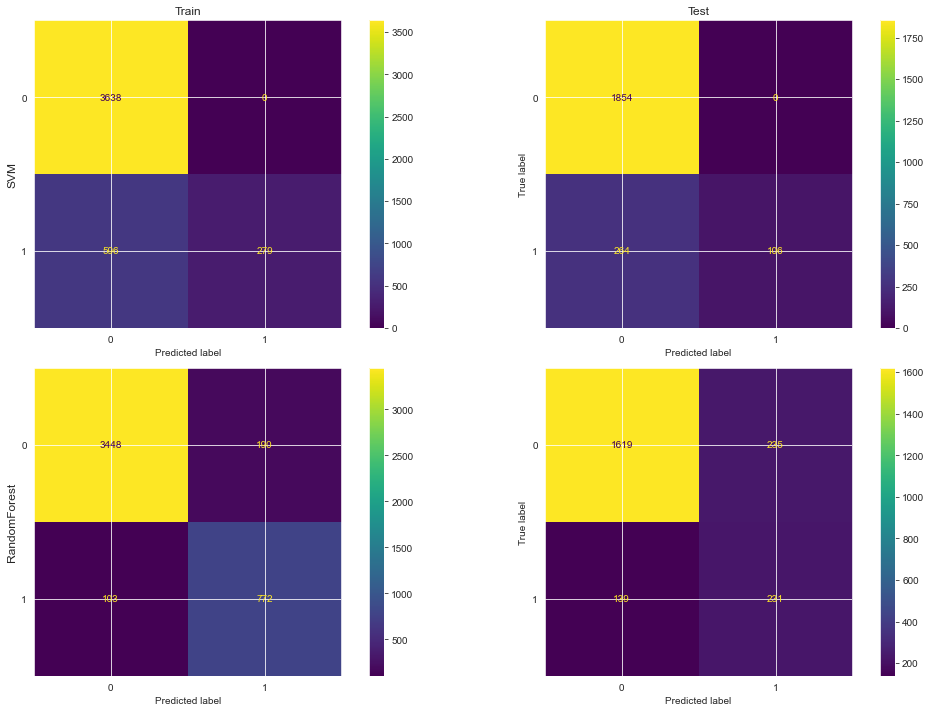

In [60]:
param_svm = {
    'svc__C' : [0.0001,0.001,1,5,10],
    'svc__kernel': ['rbf'],
    'svc__gamma' : [0.0001,0.0005,0.005]
}


param_rf = {
    'randomforestclassifier__n_estimators':[150,200,250,300],
    'randomforestclassifier__max_depth' : [6,7,8],
    'randomforestclassifier__criterion' : ['gini','entropy'],
    'randomforestclassifier__random_state': [42]
}


oversampling = [RandomOverSampler(),ADASYN(),SMOTE()]
oversamplers = ['ROSE','ADASYN','SMOTE']
modelos = ['SVM','RandomForest']
estimators = [SVC(),RandomForestClassifier()]
parametros = [param_svm,param_rf]
entrenados = []


for algo,sampler in zip(oversampling,oversamplers):
    print(sampler)
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        imblearn_pipeline = make_pipeline(algo, estimador)
        grid_imba = GridSearchCV(imblearn_pipeline, param_grid=params,scoring='accuracy',refit = True,n_jobs=-1)
        grid_imba.fit(X_train, Y_train)
        print(modelo)
        print('Mejores parametros:',grid_imba.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(grid_imba.score(X_test,Y_test),
                                                                                     recall_score(Y_test,grid_imba.predict(X_test)),
                                                                                     precision_score(Y_test,grid_imba.predict(X_test))))

        plot_confusion_matrix(grid_imba,
                            X_train,
                            Y_train,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(grid_imba,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')


    for ax,col in zip(axes[0],['Train','Test']):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], modelos):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

## Combine

SMOTE+Tomek
Resampled dataset shape Counter({0: 3655, 1: 3655})
SVM
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 86.92% test recall 28.68% test precision 100.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 84.44% test recall 64.22% test precision 56.71%


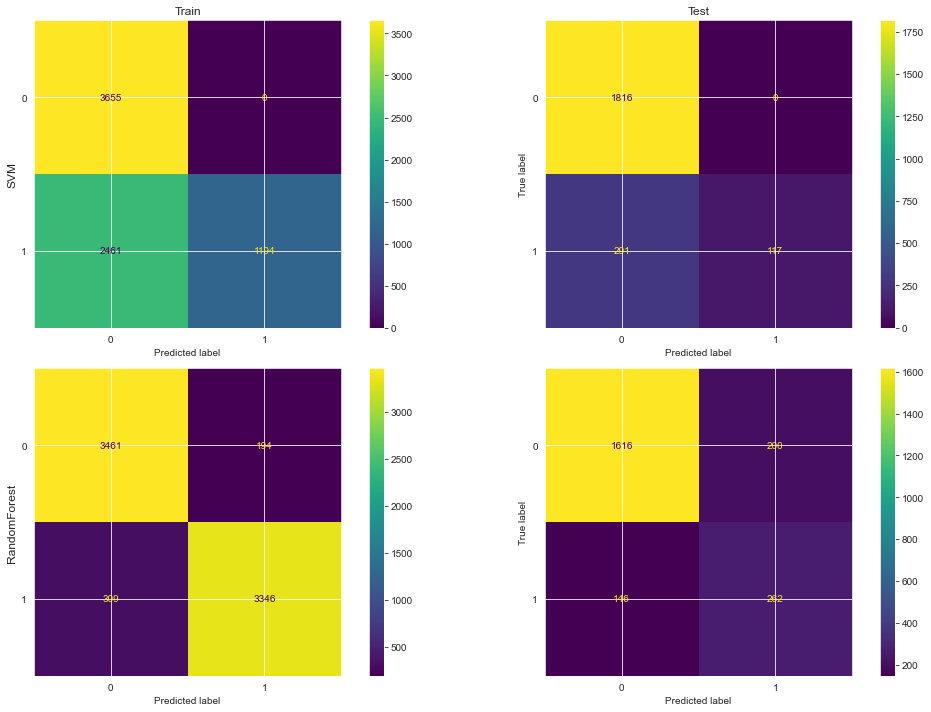

SMOTE+NN
Resampled dataset shape Counter({1: 3368, 0: 2396})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 86.92% test recall 28.68% test precision 100.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 77.16% test recall 75.25% test precision 43.00%


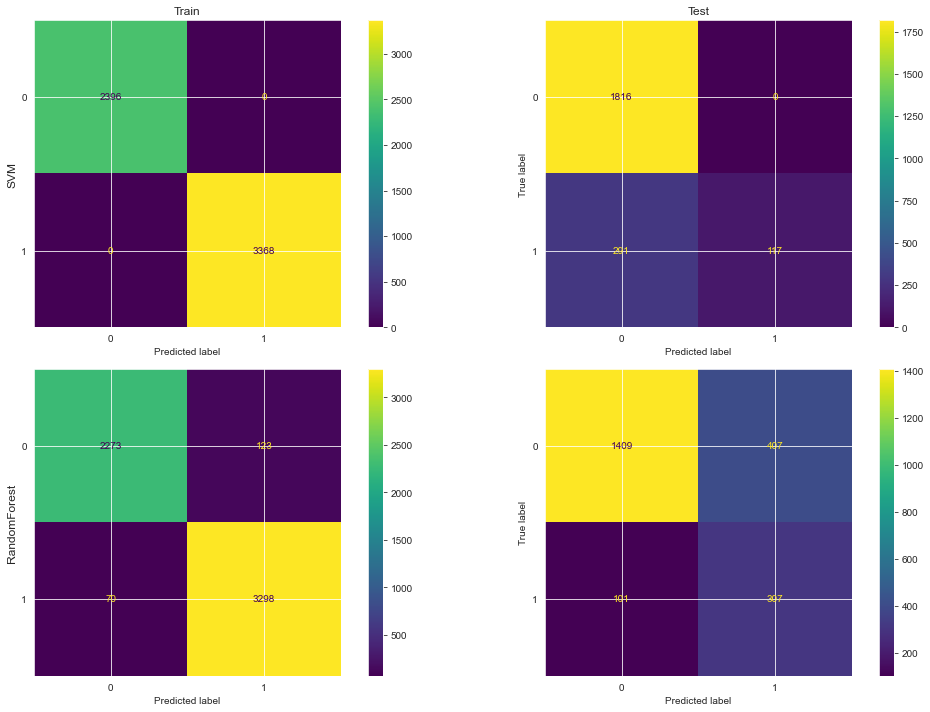

In [24]:
param_svm = {
    'C' : [0.0001,0.001,1,5,10],
    'kernel': ['rbf'],
    'gamma' :[0.0001,0.0005,0.005]
}


param_rf = {
    'n_estimators':[150,200,250,300],
    'max_depth' : [6,7,8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}

modelos = ['SVM','RandomForest']
estimators = [SVC(),RandomForestClassifier()]
parametros = [param_svm,param_rf]
oversampling = [SMOTETomek(),SMOTEENN()]
oversamplers = ['SMOTE+Tomek','SMOTE+NN']
entrenados = []

for algo,sampler in zip(oversampling,oversamplers):
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    print(sampler)
    X_res, y_res = algo.fit_resample(X_train, Y_train)
    print('Resampled dataset shape %s' % Counter(y_res))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):

        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
        busqueda.fit(X_res,y_res)
        print(modelo)
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                     recall_score(Y_test,busqueda.predict(X_test)),
                                                                                     precision_score(Y_test,busqueda.predict(X_test))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

        for ax,col in zip(axes[0],['Train','Test']):
            ax.set_title(col)
        for ax, row in zip(axes[:,0], modelos):
            ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()